In [2]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
# from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import scipy
from tqdm import tqdm
import gc

In [3]:
def dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE, RESIZE))

            IMG.append(np.array(img))
    return IMG


benign_train = np.array(dataset_loader('benign', 224))
malign_train = np.array(dataset_loader('malignant', 224))
benign_test = np.array(dataset_loader('benign/validation', 224))
malign_test = np.array(dataset_loader('malignant/validation', 224))

benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis=0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis=0)
X_test = np.concatenate((benign_test, malign_test), axis=0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis=0)

100%|████████████████████████████████████████████████████████████| 211/211 [00:02<00:00, 73.47it/s]


In [4]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

w = 60
h = 40
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 3

<Figure size 1080x1080 with 0 Axes>

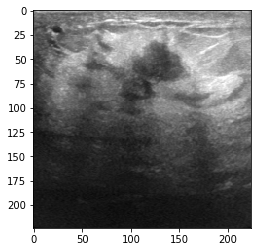

In [5]:
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()


BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
    )


def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [6]:
resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

model = build_model(resnet, lr=1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

In [7]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1, factor=0.2, min_lr=1e-7)

filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
33/32 [==============================] - ETA: -5s - loss: 0.7748 - accuracy: 0.6151
Epoch 00001: val_accuracy improved from -inf to 0.65385, saving model to weights.best.hdf5
32/32 [==============================] - 324s 9s/step - loss: 0.7748 - accuracy: 0.6151 - val_loss: 2558.5671 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 2/20
33/32 [==============================] - ETA: -6s - loss: 0.6705 - accuracy: 0.6712
Epoch 00002: val_accuracy did not improve from 0.65385
32/32 [==============================] - 308s 10s/step - loss: 0.6705 - accuracy: 0.6712 - val_loss: 2622.9487 - val_accuracy: 0.3462 - lr: 0.0010
Epoch 3/20
33/32 [==============================] - ETA: -6s - loss: 0.6549 - accuracy: 0.6634
Epoch 00003: val_accuracy did not improve from 0.65385
32/32 [==============================] - 313s 10s/step - loss: 0.6549 - accuracy: 0.6634 - val_loss: 2007.0846 - val_accuracy: 0.3462 - lr: 0.0010
Epoch 4/20
33/32 [==============================] - ETA: -6s - loss: 0.664

In [8]:
model.load_weights("weights.best.hdf5")
Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

Y_pred = model.predict(X_test)

tta_steps = 10
predictions = []

In [9]:
for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps=len(X_test) / BATCH_SIZE)

    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

print(cm)

from sklearn.metrics import classification_report
report = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
print(report)

100%|█████████████████████████████████████████████████████████████| 10/10 [16:53<00:00, 101.38s/it]

[[454   0]
 [211   0]]
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       454
           1       0.00      0.00      0.00       211

    accuracy                           0.68       665
   macro avg       0.34      0.50      0.41       665
weighted avg       0.47      0.68      0.55       665




d:\py\5course\venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\py\5course\venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\py\5course\venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
